SigOpt Example
-------------

In this example we will show how to use the python client library for [SigOpt](https://sigopt.com) to optimize the [EggHolder problem](http://www.sfu.ca/~ssurjano/egg.html), a classic optimization problem.

We will then compare how SigOpt performs against standard optimization methods like [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search), [random search](https://en.wikipedia.org/wiki/Random_search), and various [scipy optimization methods](http://docs.scipy.org/doc/scipy/reference/optimize.html).

We find that SigOpt finds better results, faster.

In [1]:
import numpy

class Objective(object):
    """The Objective function to maximize.
    
    Replace with any function or time consuming and expensive process.
    """
    
    def __init__(self):
        self.parameters = [
            {'name': 'x1',
             'type': 'double',
             'bounds': { 'min': -70.0, 'max': 70.0 },
            },
            {'name': 'x2',
             'type': 'double',
             'bounds': { 'min': -70.0, 'max': 70.0 },
            },
        ]
        self.plotting_bounds = {'min': -250, 'max': 250}

    @staticmethod
    def evaluate(params):
        """Returns the results of our objective function given a dict of parameters."""
        # EggHolder function - http://www.sfu.ca/~ssurjano/egg.html
        return -(params['x2'] + 47) * \
            numpy.sin(numpy.sqrt(abs(params['x2'] + params['x1'] / 2 + 47))) - \
            params['x1'] * numpy.sin(numpy.sqrt(abs(params['x1'] - (params['x2'] + 47))))
    
    def within_bounds(self, params):
        return all(((
            param['bounds']['min'] < params[param['name']] < param['bounds']['max']
            for param
            in self.parameters
        )))
    
obj = Objective()

In [3]:
import sigopt
# Find your SigOpt creds at https://sigopt.com/tokens

conn = sigopt.Connection(client_token='YOUR_CLIENT_TOKEN_GOES_HERE')
SIGOPT_TOTAL = 40

experiment = conn.experiments().create(
  name='SigOpt Introduction Example',
  project='sigopt-examples',
  metrics=[dict(name='value', objective='maximize')],
  parameters=obj.parameters,
  observation_budget=SIGOPT_TOTAL,
)

print "You can track your experiment at https://sigopt.com/experiment/{0}".format(experiment.id)

You can track your experiment at https://sigopt.com/experiment/42933


In [4]:
import time

for i in range(experiment.observation_budget):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    obj_val = obj.evaluate(suggestion.assignments)
    
    # Note: SigOpt was designed to optimze time consuming and expensive processes like
    # tuning ML models, optimizing complex simulations, or running optimal A/B tests.
    # We simulate the evaluation taking 100ms here to allow SigOpt time to find the best
    # possible suggestion. In practice this is not an issue when the underlying evaluation
    # is time consuming or expensive enough to warrant the use of SigOpt.
    time.sleep(0.1)
    
    conn.experiments(experiment.id).observations().create(
      suggestion=suggestion.id,
      value=obj_val,
    )
    print "Created observation {0}/{1}".format(i+1, experiment.observation_budget)

print "Optimization done. View results at https://sigopt.com/experiment/{0}".format(experiment.id)

for best_assignments in conn.experiments(experiment.id).best_assignments().fetch().iterate_pages():
    print "Best value found: {0} at {1}".format(best_assignments.value, best_assignments.assignments)

Created observation 1/40
Created observation 2/40
Created observation 3/40
Created observation 4/40
Created observation 5/40
Created observation 6/40
Created observation 7/40
Created observation 8/40
Created observation 9/40
Created observation 10/40
Created observation 11/40
Created observation 12/40
Created observation 13/40
Created observation 14/40
Created observation 15/40
Created observation 16/40
Created observation 17/40
Created observation 18/40
Created observation 19/40
Created observation 20/40
Created observation 21/40
Created observation 22/40
Created observation 23/40
Created observation 24/40
Created observation 25/40
Created observation 26/40
Created observation 27/40
Created observation 28/40
Created observation 29/40
Created observation 30/40
Created observation 31/40
Created observation 32/40
Created observation 33/40
Created observation 34/40
Created observation 35/40
Created observation 36/40
Created observation 37/40
Created observation 38/40
Created observation 3

Visualizing the Results
----------------------

In [5]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

def plot_obj_func(obj, res=64, history=None):
    x = numpy.linspace(
        obj.parameters[0]['bounds']['min'],
        obj.parameters[0]['bounds']['max'],
        res,
    )
    y = numpy.linspace(
        obj.parameters[1]['bounds']['min'],
        obj.parameters[1]['bounds']['max'],
        res,
    )
    X, Y = numpy.meshgrid(x, y)
    Z = numpy.zeros((res, res))
    
    for i, p1 in enumerate(x):
        for j, p2 in enumerate(y):
            params = {
                obj.parameters[0]['name']: p1,
                obj.parameters[1]['name']: p2,
            }
            Z[j][i] = obj.evaluate(params)
    
    fig = plt.figure(figsize=(24, 7))
    ax_3d = fig.add_subplot(131, projection='3d')
    ax_3d.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    
    ax_contour = fig.add_subplot(132)
    ax_contour.contour(X, Y, Z)
    ax_contour.set_xlabel(obj.parameters[0]['name'])
    ax_contour.set_ylabel(obj.parameters[1]['name'])
  
    best_so_far = -numpy.inf
    best_hist = []
    true_val = []
    
    if history is not None:
        for params in history:
            obj_value = obj.evaluate(params)
            if obj_value > best_so_far:
                best_so_far = obj_value
            best_hist.append(best_so_far)
            true_val.append(obj_value)
            
            xval = params[obj.parameters[0]['name']]
            yval = params[obj.parameters[1]['name']]
            
            ax_3d.plot([xval], [yval], obj.evaluate(params), 'k*')
            ax_contour.plot([xval], [yval], 'k*')
            
    
    ax_best = fig.add_subplot(133)
    ax_best.plot(best_hist, 'bo--')
    ax_best.plot(true_val, 'b*')
    ax_best.set_ylim(
        obj.plotting_bounds['min'],
        obj.plotting_bounds['max']
    )
    ax_best.set_xlabel("Number of Evaluations")
    ax_best.set_ylabel("Best Value Observed")

    plt.show()    
    
    print "Best value found: {0}".format(best_so_far)
    return best_hist

total_hist = {}

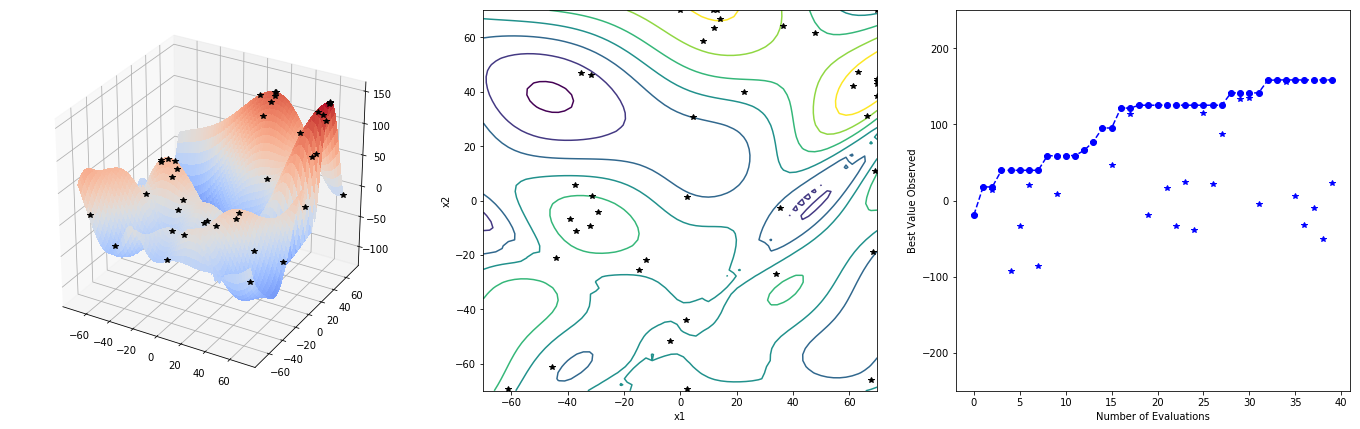

Best value found: 158.467506799


In [6]:
history = list(conn.experiments(experiment.id).observations().fetch().iterate_pages())
history = sorted(history, key=lambda obs: obs.to_json()['created'])
sigopt_history = [obs.assignments for obs in history]

total_hist['sigopt'] = plot_obj_func(obj, history=sigopt_history)

We can see that SigOpt is able to find the global optima within about 40 iterations. In practice we find that SigOpt usually takes around 2 to 10 times the dimensionality of the problem to find the optima. For highly multimodal problems this can be as high as 20 times the dimensionality as it is here.

Other Methods
-------------

We will compare the SigOpt results to other standard optimization methods like

1. [Grid Search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search)
2. [Random Search](https://en.wikipedia.org/wiki/Random_search)
3. [Powell](http://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html) (local search)
4. [Nelder-Mead](http://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html) (local search)
5. [Basin Hopping](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html#scipy.optimize.basinhopping)
6. [Differential Evolution](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#scipy.optimize.differential_evolution)

Note: For the local search methods the choice of starting point is key. Often this is overcome by multistarting these methods in combination with Grid Search or Random Search, but this only increases the total number of evaluations required to find the optimal solution. This can become intractable for the time consuming and expensive evaluations SigOpt was designed to help with like [tuning ML models](http://blog.sigopt.com/post/111903668663/tuning-machine-learning-models) or [optimizing complex simulations](http://blog.sigopt.com/post/130771597853/making-a-better-airplane-using-sigopt-and-rescale).

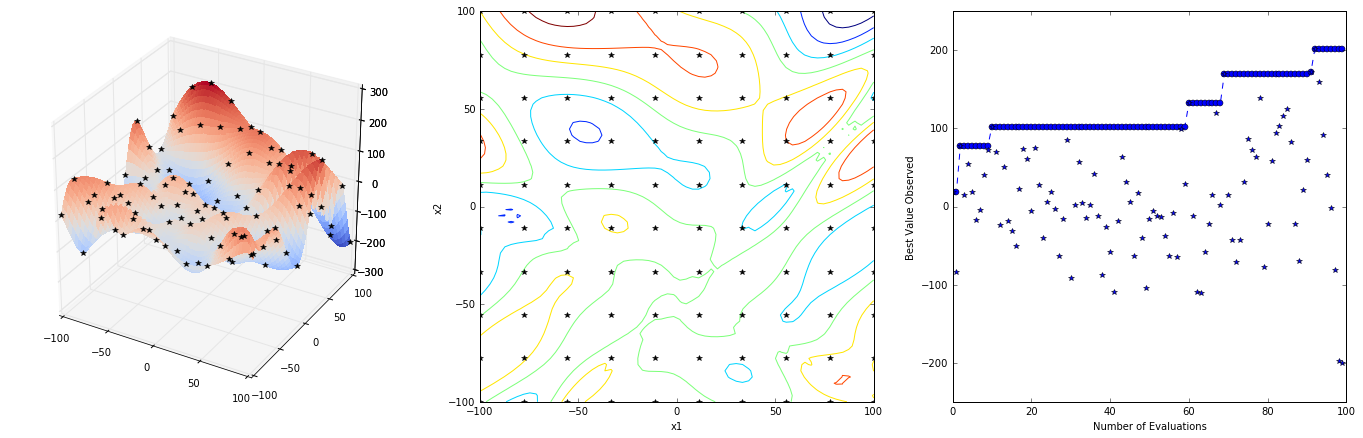

Best value found: 201.872897355


In [6]:
GRIDSEARCH_RES = 10

gridsearch_history = []

x_space = numpy.linspace(
        obj.parameters[0]['bounds']['min'],
        obj.parameters[0]['bounds']['max'],
        GRIDSEARCH_RES,
    )
y_space = numpy.linspace(
        obj.parameters[1]['bounds']['min'],
        obj.parameters[1]['bounds']['max'],
        GRIDSEARCH_RES,
    )

for p2 in x_space:
    for p1 in y_space:
        gridsearch_history.append({
                obj.parameters[0]['name']: p1,
                obj.parameters[1]['name']: p2,
            })
        
total_hist['gridsearch'] = plot_obj_func(obj, history=gridsearch_history)

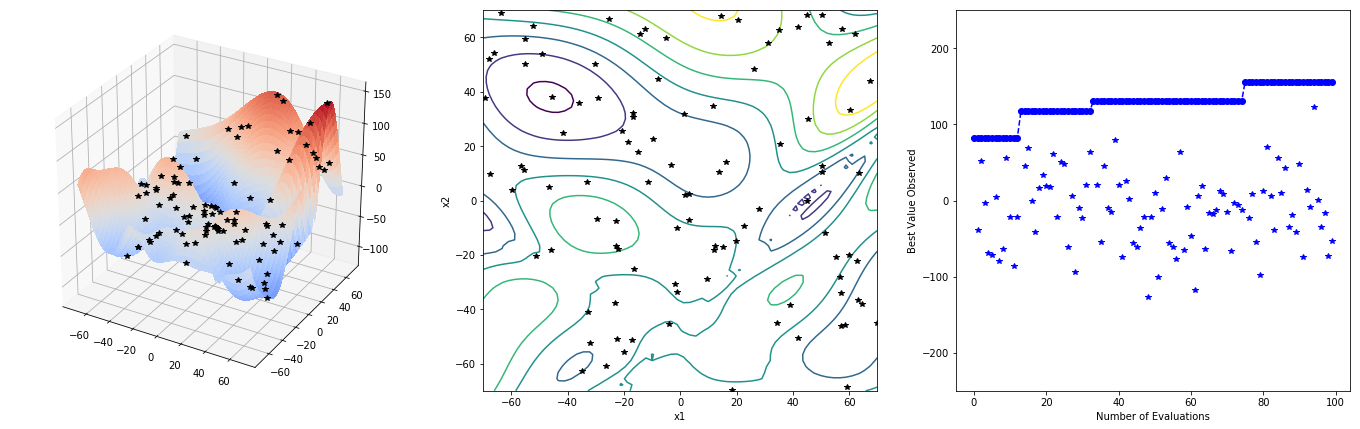

Best value found: 156.198289064


In [7]:
RANDOMSEARCH_TOTAL = 100

randomsearch_history = []
for _ in range(RANDOMSEARCH_TOTAL):
    params = {}
    for param in obj.parameters:
        params[param['name']] = numpy.random.uniform(
                param['bounds']['min'],
                param['bounds']['max'],
            )
    randomsearch_history.append(params)
    
total_hist['randomsearch'] = plot_obj_func(obj, history=randomsearch_history)

In [8]:
import scipy.optimize

def scipy_opt(obj, method=None, x0=[0,0]):

    scipy_history = []

    def scipy_obj_func_wrapper(x):     
        params = {
            obj.parameters[0]['name']: x[0],
            obj.parameters[1]['name']: x[1],
        }
        
        if not obj.within_bounds(params):
            return 1e8
        
        scipy_history.append(params)
        # scipy wants to minimize
        return -obj.evaluate(params)

    scipy.optimize.minimize(scipy_obj_func_wrapper, x0, method=method)

    return(scipy_history)

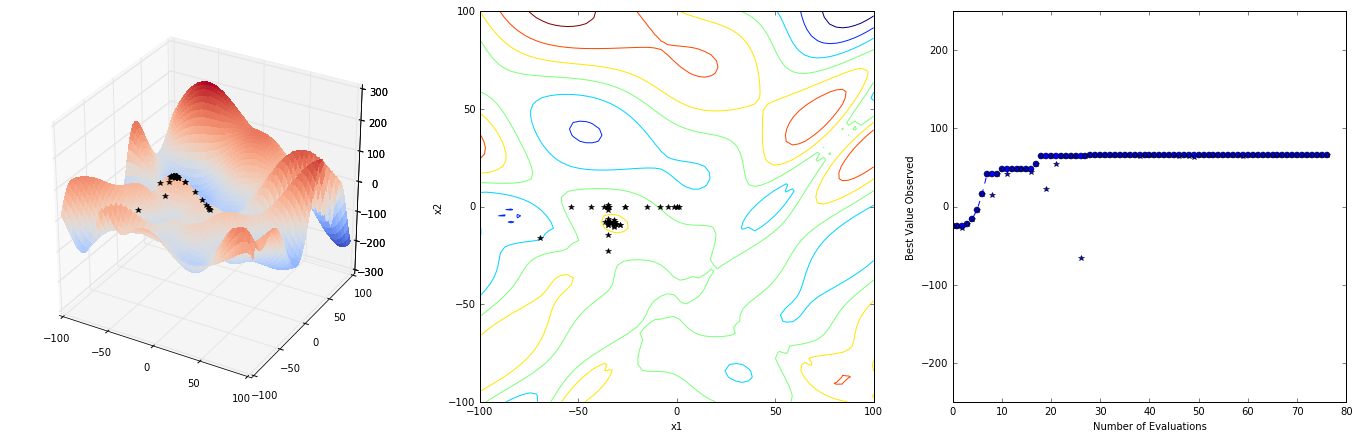

Best value found: 65.9140390166


In [9]:
total_hist['Powell'] = plot_obj_func(obj, history=scipy_opt(obj, method='Powell'))

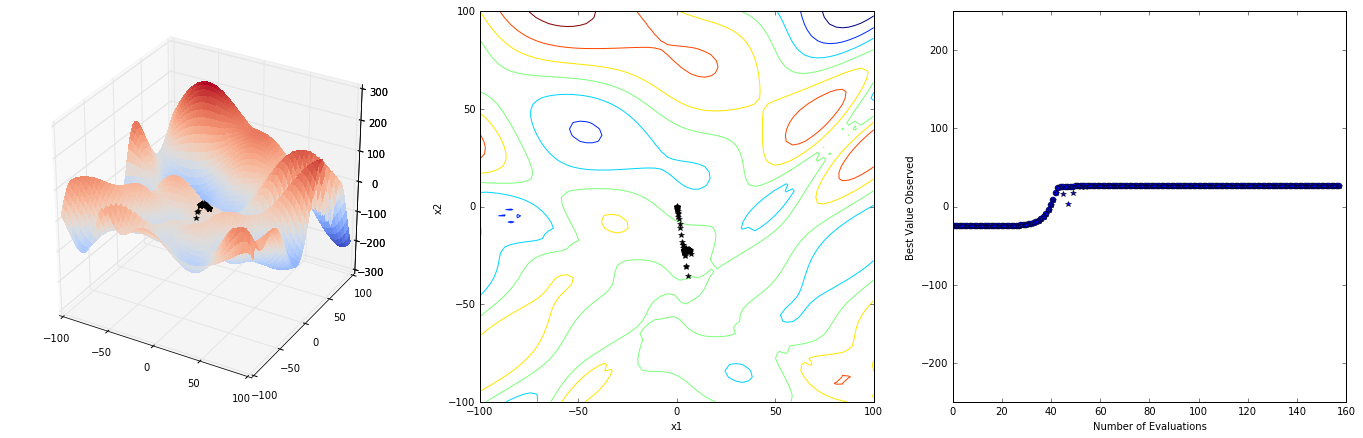

Best value found: 26.6249361558


In [10]:
total_hist['Nelder-Mead'] = plot_obj_func(obj, history=scipy_opt(obj, method='Nelder-Mead'))

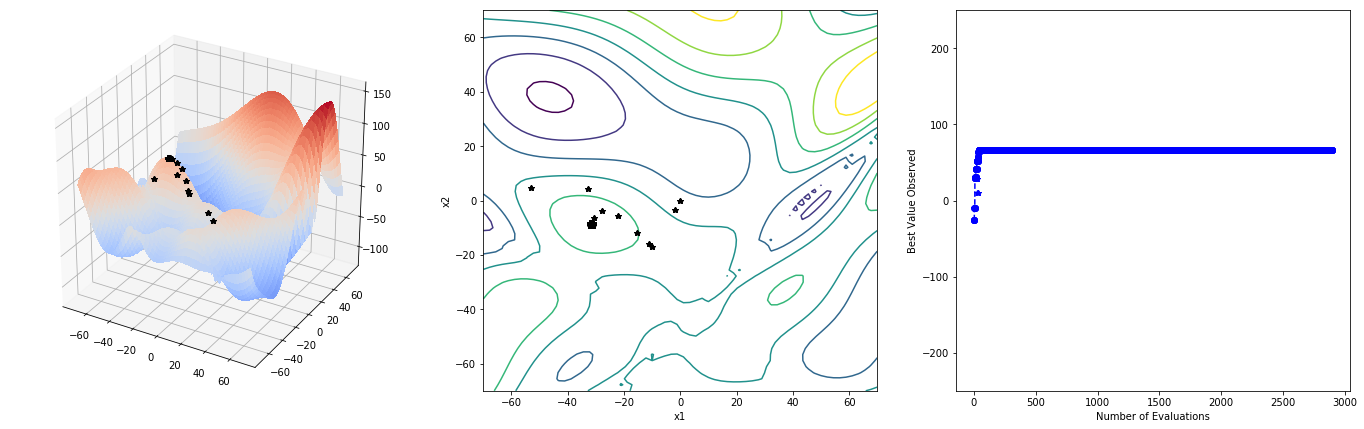

Best value found: 65.9140390166


In [9]:
basinhopping_history = []

def scipy_obj_func_wrapper(x):     
    params = {
        obj.parameters[0]['name']: x[0],
        obj.parameters[1]['name']: x[1],
    }

    if not obj.within_bounds(params):
        return 1e8

    basinhopping_history.append(params)
    # scipy wants to minimize
    return -obj.evaluate(params)

scipy.optimize.basinhopping(scipy_obj_func_wrapper, [0, 0])

total_hist['basinhopping'] = plot_obj_func(obj, history=basinhopping_history)

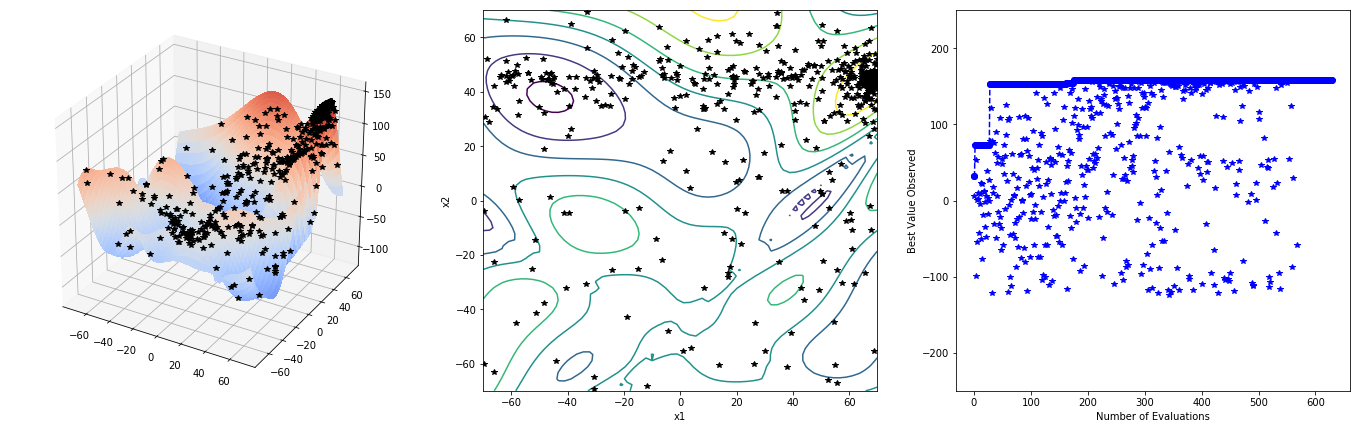

Best value found: 158.554164407


In [10]:
differential_evolution_history = []

def scipy_obj_func_wrapper(x):     
    params = {
        obj.parameters[0]['name']: x[0],
        obj.parameters[1]['name']: x[1],
    }

    if not obj.within_bounds(params):
        return 1e8

    differential_evolution_history.append(params)
    # scipy wants to minimize
    return -obj.evaluate(params)

scipy.optimize.differential_evolution(scipy_obj_func_wrapper, [
        (
            obj.parameters[0]['bounds']['min'],
            obj.parameters[0]['bounds']['max'],
        ),
        (
            obj.parameters[1]['bounds']['min'],
            obj.parameters[1]['bounds']['max'],
        ),
    ])

total_hist['differential_evolution'] = plot_obj_func(obj, history=differential_evolution_history)

Results
-------

We see that SigOpt is able to find better results in less function evaluations than all standard methods.

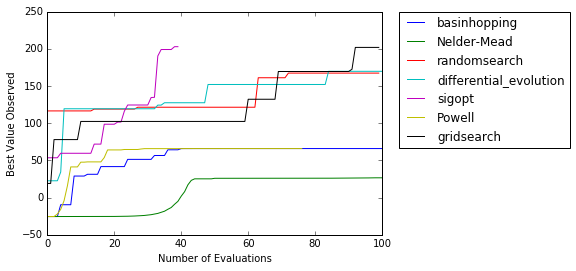

In [15]:
def plot_total_hist():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for opt_name, history in total_hist.iteritems():
        ax.plot(history, label=opt_name)
        
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlim(0,100)
    ax.set_xlabel("Number of Evaluations")
    ax.set_ylabel("Best Value Observed")

plot_total_hist()

[SigOpt](www.sigopt.com) Finds better results, faster than all other methods. When every evaluation is time consuming or expensive SigOpt can guide you to better results with less trial and error.